<a href="https://colab.research.google.com/github/meiladrahmani556/Disso/blob/main/notebooks/05_model_2_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Standard imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Paths
DATA_DIR = "../data"

In [14]:
!mkdir -p /content/data
!kaggle datasets download -d puneet6060/intel-image-classification -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 96% 332M/346M [00:03<00:00, 86.4MB/s]
100% 346M/346M [00:03<00:00, 109MB/s] 


In [15]:
%%writefile kaggle.json
{
  "username": "meiladrahmani",
  "key": "KGAT_92da668157bd4281a45c8eb0fec30e6f"
}

Overwriting kaggle.json


In [16]:
!mkdir -p /root/.config/kaggle
!cp kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

!kaggle datasets list | head

ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                             3491  2025-12-11 15:29:14.327000           2114        287  1.0              
suvidyasonawane/student-academic-placement-performance-dataset    Student Academic Placement Performance Dataset           94469  2026-01-11 02:02:47.837000              0         27  1.0              
neurocipher/student-performance                                   Student Performance                                      49705  2025-12-12 12:06:28.973000           1261        161  1.0     

In [ ]:
!mkdir -p /content/data
!kaggle datasets download -d puneet6060/intel-image-classification -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98% 340M/346M [00:00<00:00, 590MB/s]
100% 346M/346M [00:00<00:00, 641MB/s]


In [ ]:
import os
print(os.listdir("/content/data")[:20])

['seg_test', 'seg_train', 'seg_pred']


In [ ]:
DATA_DIR = "/content/data"
TRAIN_DIR = os.path.join(DATA_DIR, "seg_train", "seg_train")
TEST_DIR  = os.path.join(DATA_DIR, "seg_test", "seg_test")

print("TRAIN_DIR:", TRAIN_DIR, os.path.exists(TRAIN_DIR))
print("TEST_DIR :", TEST_DIR, os.path.exists(TEST_DIR))
print("Classes in TRAIN_DIR:", os.listdir(TRAIN_DIR))

TRAIN_DIR: /content/data/seg_train/seg_train True
TEST_DIR : /content/data/seg_test/seg_test True
Classes in TRAIN_DIR: ['street', 'forest', 'glacier', 'sea', 'mountain', 'buildings']


In [ ]:
import os, random, numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=SEED,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=SEED,
    shuffle=False
)

num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)
print("Num classes:", num_classes)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Num classes: 6


In [ ]:
model2 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    layers.Conv2D(32, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.30),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.50),

    layers.Dense(num_classes, activation="softmax")
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,713,798 (40.87 MB)

 Trainable params: 10,712,838 (40.87 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint("model_2_best.keras", monitor="val_accuracy", save_best_only=True)
]

In [12]:
EPOCHS = 15

history2 = model2.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1205s 3s/step - accuracy: 0.5578 - loss: 1.2158 - val_accuracy: 0.2040 - val_loss: 2.6398 - learning_rate: 0.0010
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1109s 3s/step - accuracy: 0.7080 - loss: 0.7919 - val_accuracy: 0.6944 - val_loss: 0.8309 - learning_rate: 0.0010
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1201s 3s/step - accuracy: 0.7485 - loss: 0.6842 - val_accuracy: 0.6897 - val_loss: 0.9435 - learning_rate: 0.0010
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1127s 3s/step - accuracy: 0.7693 - loss: 0.6292 - val_accuracy: 0.6851 - val_loss: 0.9210 - learning_rate: 0.0010
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1123s 3s/step - accuracy: 0.7966 - loss: 0.5608 - val_accuracy: 0.7158 - val_loss: 0.8040 - learning_rate: 5.0000e-04
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1144s 3s/step - accuracy: 0.8051 - loss: 0.5241 - val_accuracy: 0.7044 - val_loss: 0.8148 - learning_rate: 5.0000e-04
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1109s 3s/step - accuracy: 0.

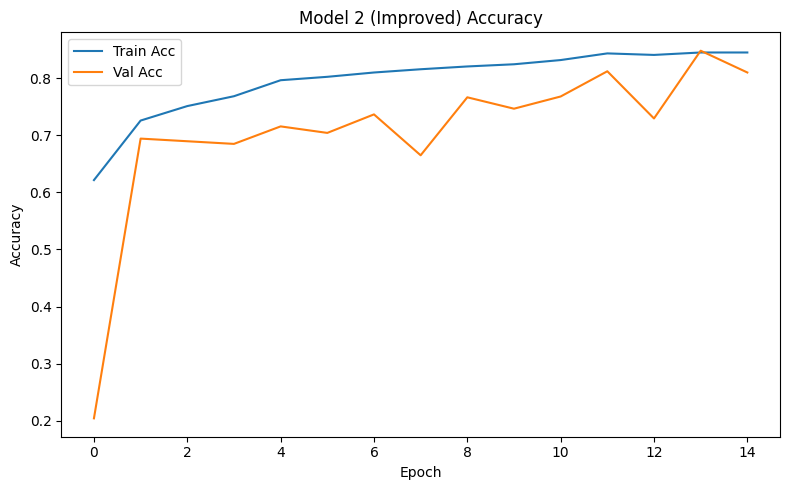

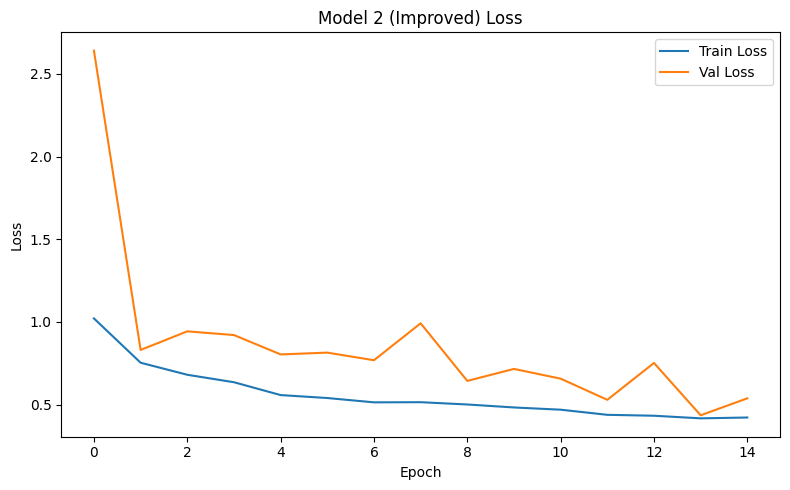

In [17]:
plt.figure(figsize=(8,5))
plt.plot(history2.history["accuracy"], label="Train Acc")
plt.plot(history2.history["val_accuracy"], label="Val Acc")
plt.title("Model 2 (Improved) Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history2.history["loss"], label="Train Loss")
plt.plot(history2.history["val_loss"], label="Val Loss")
plt.title("Model 2 (Improved) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model2.save("model_2_final.keras")
print("Saved: model_2_best.keras and model_2_final.keras")